<a href="https://colab.research.google.com/github/maxiuboldi/challenge_ml/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Science Challenge Mercado Libre - BI Team

## Instalar dependencias

In [1]:
!pip install cherrypicker

## Importar librerias

In [2]:
import urllib.request
import urllib.parse
import json
import pandas as pd
import numpy as np
from math import ceil
from cherrypicker import CherryPicker
from time import sleep
import gc
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns 
import matplotlib.pyplot as plt

## Contantes

In [3]:
# API ML
URL_CATEGORIES = 'https://api.mercadolibre.com/sites/MLA/categories'
URL_CHILD_CATEGORIES = 'https://api.mercadolibre.com/categories/'
URL_SEARCH = 'https://api.mercadolibre.com/sites/MLA/search?'
LIMIT_CALLS = 1050 / 50
SLEEP = 0  # No encontré en la documentación límites, pero por las dudas...

# Modelo
SEED = 8888
K_FOLD = 10
TEST_SIZE = 0.20

# Opciones de Pandas
pd_options = {
'display.max_rows': None,
'display.max_columns': None,
'display.width': None,
'display.float_format': '{:.2f}'.format
}
[pd.set_option(option, setting) for option, setting in pd_options.items()]

# Otras opciones
plt.rcParams['figure.figsize'] = (24, 12)
sns.set()

## Descarga de categorías

In [4]:
print('Descargando categorías {}\n'.format(URL_CATEGORIES))
with urllib.request.urlopen(URL_CATEGORIES) as handler:
    categories = json.loads(handler.read())
sleep(SLEEP)

categories_list = []
for category in categories:
    url_categorie = URL_CHILD_CATEGORIES + category.get('id')
    print('Descargando sub categorías {}'.format(url_categorie))
    with urllib.request.urlopen(url_categorie) as handler:
        category_detail = json.loads(handler.read())
        for detalle in category_detail.get('children_categories'):
            categories_list.append(detalle)
    sleep(SLEEP)

categories_df = pd.DataFrame(categories_list)
categories_df.set_index('id', inplace=True)

print('\nListo')

Descargando categorías https://api.mercadolibre.com/sites/MLA/categories

Descargando sub categorías https://api.mercadolibre.com/categories/MLA5725
Descargando sub categorías https://api.mercadolibre.com/categories/MLA1512
Descargando sub categorías https://api.mercadolibre.com/categories/MLA1403
Descargando sub categorías https://api.mercadolibre.com/categories/MLA1071
Descargando sub categorías https://api.mercadolibre.com/categories/MLA1367
Descargando sub categorías https://api.mercadolibre.com/categories/MLA1368
Descargando sub categorías https://api.mercadolibre.com/categories/MLA1743
Descargando sub categorías https://api.mercadolibre.com/categories/MLA1384
Descargando sub categorías https://api.mercadolibre.com/categories/MLA1246
Descargando sub categorías https://api.mercadolibre.com/categories/MLA1039
Descargando sub categorías https://api.mercadolibre.com/categories/MLA1051
Descargando sub categorías https://api.mercadolibre.com/categories/MLA1648
Descargando sub categorías

## Muestreo de categorías adicionales y descarga de datos

In [5]:
print('\nMuestreando categorías')
categories_search_dict = categories_df[~categories_df['name'].str.lower().str.contains(
    r'tvs|smartphones')]['name'].sample(8, random_state=8888).to_dict()
categories_search_dict.update(categories_df[categories_df['name'].str.lower().str.contains(r'tvs|smartphones')]['name'])

print('Categorías seleccionadas')
for category, name in categories_search_dict.items():
    print(category, ': ', name)

print('Descargando resultados de búsqueda\n')
results_list = []
for category, name in categories_search_dict.items():
    print('Procesando categoría {}\n'.format(category))
    current_call = 0
    # La API sólo permite pasar un offset hasta 1.000, que devuelve un máximo de 1.050 artículos
    # con un máximo de 21 llamadas.
    for offset in range(0, 1050, 50):
        current_call += 1
        url_search_category = URL_SEARCH + urllib.parse.urlencode({'category': category, 'offset': offset})
        print('procesando {}'.format(url_search_category))
        with urllib.request.urlopen(url_search_category) as handler:
            search_result = json.loads(handler.read())
            total = search_result['paging'].get('total')
            if current_call == 1:
                print('Total de resultados: {}'.format(total))
            if total == 0:  # Por las dudas, hay categorías sin productos que pudieran salir del aleatorio
                break
            calls = ceil(total / 50)
            if current_call == 1:
                print('Total de llamadas necesarias: {}\n'.format(calls))
            results = search_result['results']
            for result in results:
                picker = CherryPicker(result)
                picker_dict = picker.flatten().get()
                picker_dict.update({'category_name': name})
                results_list.append(picker_dict)
            if current_call == calls:  # Si no hace falta llamar más, cortamos.
                break
            sleep(SLEEP)
    print('')

dataset = pd.DataFrame(results_list)
dataset.set_index('id', inplace=True)

del results_list, categories_search_dict, categories_list
gc.collect()

print('\nListo')


Muestreando categorías
Categorías seleccionadas
MLA1912 :  Otros
MLA1228 :  Otros
MLA385177 :  Climatización
MLA1700 :  Conectividad y Redes
MLA7841 :  Series de TV
MLA430687 :  Laptops y Accesorios
MLA7312 :  Maquinaria Agrícola
MLA404419 :  Insumos para Joyería
MLA1055 :  Celulares y Smartphones
MLA1002 :  TVs
Descargando resultados de búsqueda

Procesando categoría MLA1912

procesando https://api.mercadolibre.com/sites/MLA/search?category=MLA1912&offset=0
Total de resultados: 7391
Total de llamadas necesarias: 148

procesando https://api.mercadolibre.com/sites/MLA/search?category=MLA1912&offset=50
procesando https://api.mercadolibre.com/sites/MLA/search?category=MLA1912&offset=100
procesando https://api.mercadolibre.com/sites/MLA/search?category=MLA1912&offset=150
procesando https://api.mercadolibre.com/sites/MLA/search?category=MLA1912&offset=200
procesando https://api.mercadolibre.com/sites/MLA/search?category=MLA1912&offset=250
procesando https://api.mercadolibre.com/sites/MLA/s

## Un poco de limpieza teniendo en cuenta el análisis preliminar

In [6]:
# Reemplazamos cadenas vacías por nan.
dataset.replace('', np.nan, inplace=True)

# Dropeamos columnas con todos valores vacíos
dataset.dropna(axis=1, how='all', inplace=True)

# Dropeamos columnas con todos valores constantes
dataset = dataset.loc[:, (dataset != dataset.iloc[0]).any()]

# Dropeamos las variables asociadas a URL's
dataset.drop(['seller_permalink', 'seller_eshop_eshop_logo_url', 'permalink', 
              'thumbnail', 'seller_car_dealer_logo', 'seller_home_image_url'],
             axis=1, inplace=True)

# Nos quedamos con las variables que parecieran relevantes para un análisis preliminar.
# TODO, revisar las variables de atributos para parsearlas correctamente.
dataset = dataset[['seller_registration_date', 'seller_car_dealer', 'seller_eshop_eshop_status_id',
                   'seller_seller_reputation_transactions_total', 'seller_seller_reputation_transactions_canceled',
                   'seller_seller_reputation_transactions_ratings_negative',
                   'seller_seller_reputation_transactions_ratings_positive',
                   'seller_seller_reputation_transactions_ratings_neutral',
                   'seller_seller_reputation_transactions_completed', 'seller_seller_reputation_power_seller_status',
                   'seller_seller_reputation_metrics_claims_rate', 'seller_seller_reputation_metrics_claims_value',
                   'seller_seller_reputation_metrics_delayed_handling_time_rate',
                   'seller_seller_reputation_metrics_delayed_handling_time_value',
                   'seller_seller_reputation_metrics_sales_completed',
                   'seller_seller_reputation_metrics_cancellations_rate',
                   'seller_seller_reputation_metrics_cancellations_value', 'seller_seller_reputation_level_id', 'price',
                   'currency_id', 'available_quantity', 'sold_quantity', 'buying_mode', 'listing_type_id', 'condition',
                   'installments_quantity', 'installments_amount', 'installments_rate', 'shipping_free_shipping',
                   'shipping_mode', 'seller_address_state_name', 'original_price', 'official_store_id', 'domain_id',
                   'category_name', 'seller_seller_reputation_metrics_claims_excluded_real_rate',
                   'seller_seller_reputation_metrics_claims_excluded_real_value',
                   'seller_seller_reputation_metrics_delayed_handling_time_excluded_real_rate',
                   'seller_seller_reputation_metrics_delayed_handling_time_excluded_real_value',
                   'seller_seller_reputation_metrics_cancellations_excluded_real_rate',
                   'seller_seller_reputation_metrics_cancellations_excluded_real_value',
                   'seller_seller_reputation_real_level', 'seller_eshop_eshop_rubro_name']]

# Antigüedad del vendedor
dataset['seller_registration_date'] = pd.to_datetime(dataset['seller_registration_date']).dt.tz_localize(None).dt.normalize()
dataset['seller_year_aprox'] = round((pd.to_datetime('now').normalize() - dataset['seller_registration_date']).dt.days.fillna(0) / 360).astype('int32')

# Marca de tienda oficial?
dataset['flag_official_store'] = np.where(dataset['official_store_id'].fillna(0) == 0, 'No', 'Si')

# Borramos lo que ya no sirve
dataset.drop(['seller_registration_date', 'official_store_id'], axis=1, inplace=True)

# Borramos índices duplicados
dataset = dataset[~dataset.index.duplicated(keep='first')]

## Separamos el target

In [7]:
data = dataset.loc[:, dataset.columns != 'sold_quantity'].copy()
target = dataset.loc[:, dataset.columns == 'sold_quantity'].rename(columns={'sold_quantity': 'target'}).copy()
print('Forma data: {}'.format(data.shape))
print('Forma target: {}'.format(target.shape))

Forma data: (10435, 42)
Forma target: (10435, 1)


## Removemos variables correlacionadas

In [8]:
# Matriz de correlaciones
print('Forma antes: {}'.format(data.shape))
data_corr = data.select_dtypes(include=['number']).fillna(0).corr().abs()
upper = data_corr.where(np.triu(np.ones(data_corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
data.drop(data[to_drop], axis=1, inplace=True)
print('Forma luego: {}'.format(data.shape))

Forma antes: (10435, 42)
Forma luego: (10435, 35)


## Codificamos variables categóricas

In [9]:
print('Forma antes: {}'.format(data.shape))
data_cat = data.select_dtypes(exclude=['number'])
to_drop = data_cat.columns.to_list()
enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
data_cat = pd.DataFrame(enc.fit_transform(data_cat.fillna('None')), columns=enc.get_feature_names(), index=data_cat.index)
data.drop(data[to_drop], axis=1, inplace=True)
data = data.merge(data_cat, left_index=True, right_index=True)
print('Forma luego: {}'.format(data.shape))

Forma antes: (10435, 35)
Forma luego: (10435, 177)


## Separamos en train y test

In [10]:
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=TEST_SIZE, random_state=SEED)

## Modelo de test con Regresión

In [11]:
print('Entrenando...\n')

fi = []
val_probs = []
test_probs = []
i = 0

for train_index, valid_index in KFold(n_splits=K_FOLD, shuffle=True, random_state=SEED).split(train_data, train_target):
    i += 1
    train_data_fold = train_data.iloc[train_index]
    train_target_fold = train_target.loc[train_data.index].iloc[train_index]

    val_data_fold = train_data.iloc[valid_index]
    val_target_fold = train_target.loc[train_data.index].iloc[valid_index]

    learner = LGBMRegressor(n_estimators=10000, random_state=SEED)
    learner.fit(train_data_fold, train_target_fold, early_stopping_rounds=200, eval_metric="mae",
                eval_set=[(train_data_fold, train_target_fold), (val_data_fold, val_target_fold)],
                verbose=50)

    val_probs.append(pd.Series(learner.predict(val_data_fold), index=val_data_fold.index, name="fold_" + str(i)))
    test_probs.append(pd.Series(learner.predict(test_data), index=test_data.index,
                                name="fold_" + str(i)))
    fi.append(pd.Series(learner.feature_importances_ /
                        learner.feature_importances_.sum(), index=train_data_fold.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
fi = pd.concat(fi, axis=1).mean(axis=1).sort_values(ascending=False)

print('\nListo!')

Entrenando...

Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 39.9448	training's l2: 25081.3	valid_1's l1: 45.8382	valid_1's l2: 34516
[100]	training's l1: 35.8732	training's l2: 18155	valid_1's l1: 46.7233	valid_1's l2: 34360.8
[150]	training's l1: 33.0606	training's l2: 13981.1	valid_1's l1: 47.3768	valid_1's l2: 35807.1
[200]	training's l1: 30.9415	training's l2: 11234.3	valid_1's l1: 48.1997	valid_1's l2: 36756.7
Early stopping, best iteration is:
[42]	training's l1: 41.0905	training's l2: 26671.3	valid_1's l1: 45.5309	valid_1's l2: 34749.7
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 39.8916	training's l2: 25380.4	valid_1's l1: 47.5748	valid_1's l2: 51755.4
[100]	training's l1: 35.9748	training's l2: 18733.6	valid_1's l1: 47.3235	valid_1's l2: 49589.3
[150]	training's l1: 33.4539	training's l2: 14654.8	valid_1's l1: 47.7429	valid_1's l2: 49370.6
[200]	training's l1: 31.8075	training's l2: 12036.5	valid_1's l

In [12]:
print("Performance del modelo")
print("--------------------------------------")
print('MAE {}'.format(mean_absolute_error(test_target, test_probs)))
print('MSE {}'.format(mean_squared_error(test_target, test_probs)))
print('RMSE {}'.format(mean_squared_error(test_target, test_probs, squared=False)))

Performance del modelo
--------------------------------------
MAE 45.17905992046953
MSE 21162.99101324574
RMSE 145.47505288964751


## Importancia de variables

Text(0, 0.5, 'Variables')

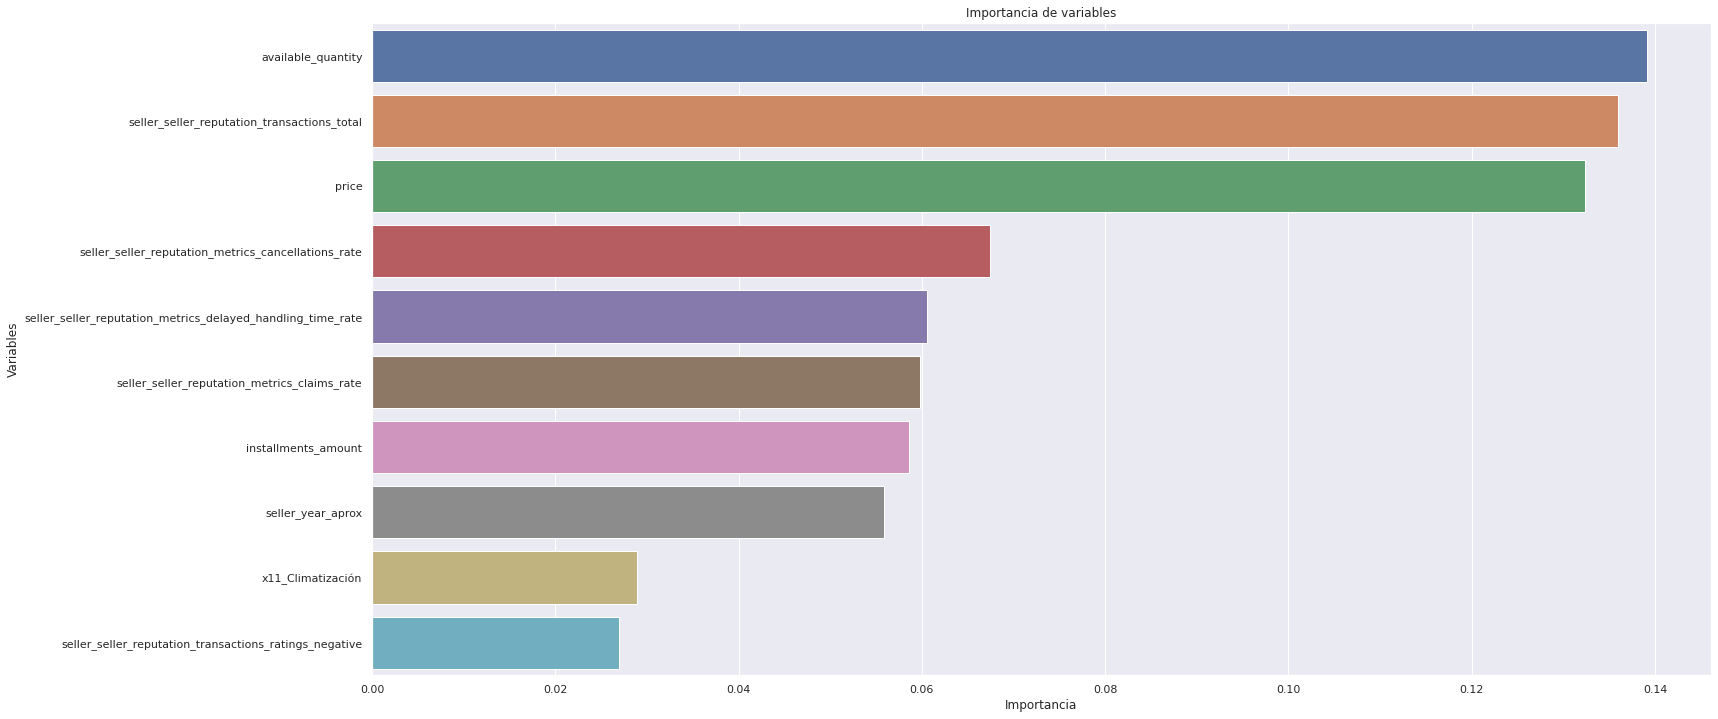

In [13]:
sns.barplot(x=fi.head(10), y=fi.head(10).index, orient='h')
#Add chart labels
plt.title('Importancia de variables')
plt.xlabel('Importancia')
plt.ylabel('Variables')

## Modelo de test con clasificación

In [16]:
target_bi = pd.Series(np.where(target['target'] > 0, 'Vende', 'No vende'), index=target.index)
print('distribución de clases: \n{}'.format(target_bi.value_counts()))

# codificamos el target
le = LabelEncoder()
target_bi = le.fit_transform(target_bi)
num_clase = le.classes_

distribución de clases: 
Vende       7545
No vende    2890
dtype: int64


## Separamos en train y test

In [17]:
train_data, test_data, train_target, test_target = train_test_split(data, target_bi, test_size=TEST_SIZE,
                                                                    random_state=SEED, stratify=target_bi)

In [20]:
fi = []
val_probs = []
test_probs = []
i = 0

for train_index, valid_index in StratifiedKFold(n_splits=K_FOLD, shuffle=True, random_state=SEED).split(train_data,
                                                                                                        train_target):
    i += 1
    train_data_fold = train_data.iloc[train_index]
    train_target_fold = train_target[train_index]

    val_data_fold = train_data.iloc[valid_index]
    val_target_fold = train_target[valid_index]

    learner = LGBMClassifier(n_estimators=10000, random_state=SEED, objective='binary')
    learner.fit(train_data_fold, train_target_fold, early_stopping_rounds=50, eval_metric="auc",
                eval_set=[(train_data_fold, train_target_fold), (val_data_fold, val_target_fold)],
                verbose=50)

    val_probs.append(pd.Series(learner.predict_proba(val_data_fold)[:, -1], name="fold_" + str(i)))
    test_probs.append(pd.Series(learner.predict_proba(test_data)[:, -1], index=test_data.index,
                                name="fold_" + str(i)))
    fi.append(pd.Series(learner.feature_importances_ /
                        learner.feature_importances_.sum(), index=train_data_fold.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
fi = pd.concat(fi, axis=1).mean(axis=1).sort_values(ascending=False)

Training until validation scores don't improve for 50 rounds.
[50]	training's binary_logloss: 0.0708535	training's auc: 0.996898	valid_1's binary_logloss: 0.125519	valid_1's auc: 0.988617
[100]	training's binary_logloss: 0.0426535	training's auc: 0.999281	valid_1's binary_logloss: 0.123188	valid_1's auc: 0.989045
[150]	training's binary_logloss: 0.0290354	training's auc: 0.999788	valid_1's binary_logloss: 0.127754	valid_1's auc: 0.989181
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.0426535	training's auc: 0.999281	valid_1's binary_logloss: 0.123188	valid_1's auc: 0.989045
Training until validation scores don't improve for 50 rounds.
[50]	training's binary_logloss: 0.0727294	training's auc: 0.996701	valid_1's binary_logloss: 0.1161	valid_1's auc: 0.990389
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.0755496	training's auc: 0.996361	valid_1's binary_logloss: 0.116577	valid_1's auc: 0.990539
Training until validation scores don't improve fo

In [22]:
def find_optimal_cutoff(true_label, prediction):
    """Encuentra la probabilidad de corte óptima para un problema de clasificación binaria basandose en la curva ROC"""
    fpr, tpr, thresh = roc_curve(true_label, prediction)
    idx = np.arange(len(tpr))
    roc = pd.DataFrame({'tf': pd.Series(tpr-(1-fpr), index=idx), 'threshold': pd.Series(thresh, index=idx)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    return list(roc_t['threshold'])

print("Performance del modelo")
print("--------------------------------------")
# predicción del resultado
threshold = find_optimal_cutoff(test_target, test_probs)
pred_target = pd.Series(np.where(test_probs > threshold[0], 1, 0), index=test_probs.index)
conf_mat = pd.DataFrame(confusion_matrix(test_target, pred_target), columns=num_clase, index=num_clase)
print("\nProbabilidad de corte: {}".format(threshold[0]))
print("\nMatriz de Confusión (filas=real, columnas=prediccion)")
print(conf_mat)
print("\nReporte de Clasificación")
print(classification_report(test_target, pred_target, target_names=['0', '1']))
print("\nAccuracy_score: {}".format(accuracy_score(test_target, pred_target)))
print("\nROC_auc_score: {}\n".format(roc_auc_score(test_target, test_probs)))

Performance del modelo
--------------------------------------

Probabilidad de corte: 0.7561268131991236

Matriz de Confusión (filas=real, columnas=prediccion)
          No vende  Vende
No vende       550     28
Vende           75   1434

Reporte de Clasificación
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       578
           1       0.98      0.95      0.97      1509

    accuracy                           0.95      2087
   macro avg       0.93      0.95      0.94      2087
weighted avg       0.95      0.95      0.95      2087


Accuracy_score: 0.9506468615237182

ROC_auc_score: 0.9890019743132897



Text(0, 0.5, 'Variables')

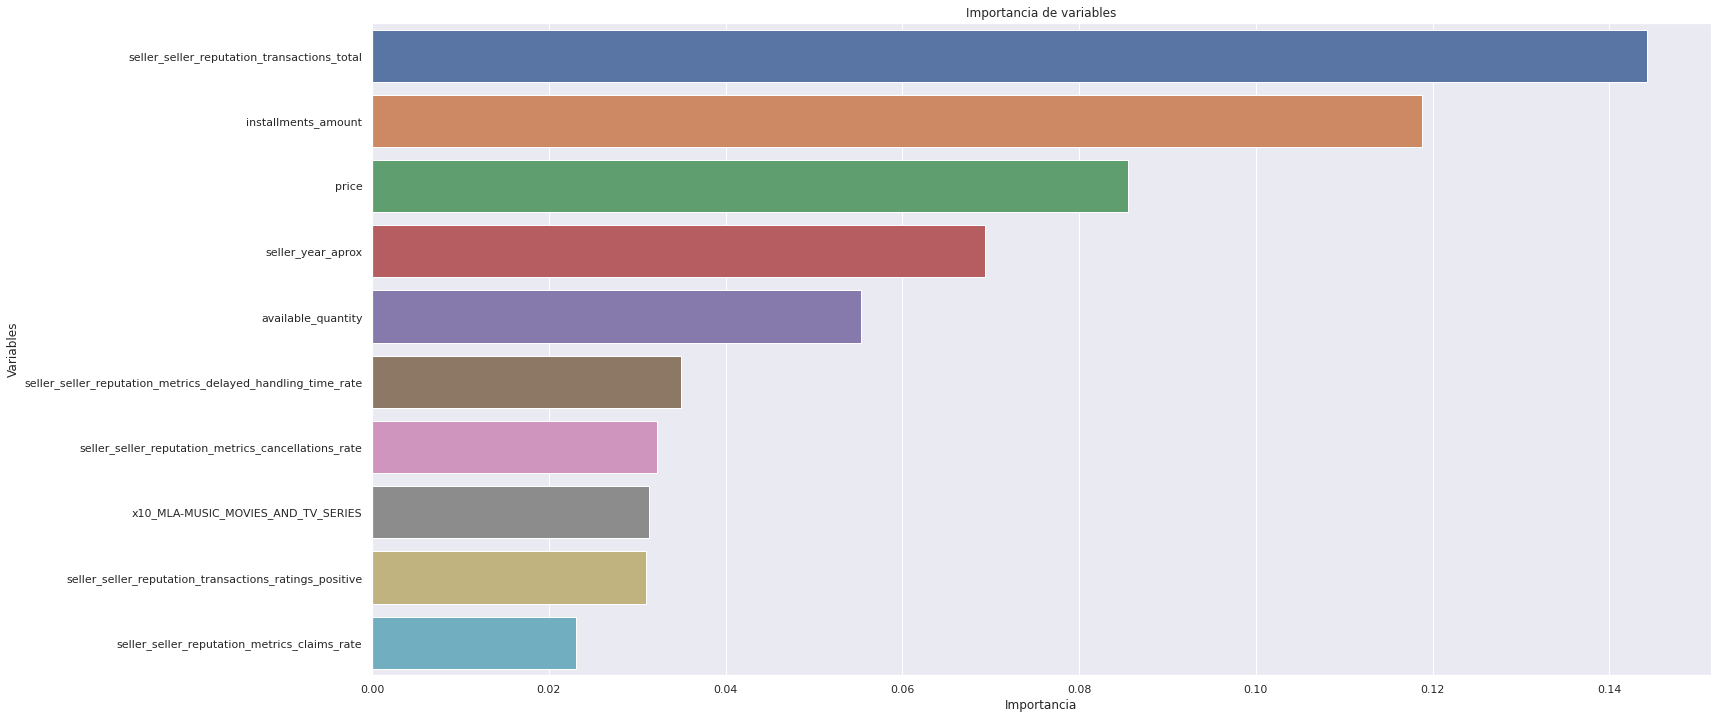

In [23]:
sns.barplot(x=fi.head(10), y=fi.head(10).index, orient='h')
#Add chart labels
plt.title('Importancia de variables')
plt.xlabel('Importancia')
plt.ylabel('Variables')